# Examine Odd MLD

In [1]:
# imports
import os
import glob
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from ocpy.utils import plotting

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle

# Load CUGN

In [3]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]
grid_tbl = items[3]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


In [5]:
high_path = os.path.join(os.getenv('OS_SPRAY'), 'CUGN', 'HighRes')
gfiles = glob.glob(os.path.join(high_path, f'SPRAY-FRSQ-{mname}-*.nc'))
hfile = gfiles[0]                   
#hfile
ds_high = xarray.open_dataset(hfile)

In [6]:
salinity = ds_high.salinity.values
temperature = ds_high.temperature.values

# Examine a Mission and Profile with a "bad" MLD

In [8]:
def do_calcs(mission_name:str, mission_profile:int, min_depth:float=5.):
    
    gidx = (grid_extrem.mission.values == mission_name) & (
        grid_extrem.mission_profile.values == mission_profile)
    gMLD = np.median(grid_extrem.MLD.values[gidx])

    # Find the obs
    my_obs = ds_high.profile_obs_index.values == mission_profile
    my_obs &= ds_high.depth.values > min_depth

    # Calculate density, etc.

    # Require finite
    my_obs &= np.isfinite(salinity) & np.isfinite(temperature)

    # Pressure
    p = conversions.p_from_z(-1*ds_high.depth.values[my_obs], lat)

    # SA
    SA = conversions.SA_from_SP(salinity[my_obs], p, lon, lat)

    # CT
    CT = conversions.CT_from_t(SA, temperature[my_obs], p)

    # sigma0 
    sigma0 = density.sigma0(SA, CT)
    srt_z = np.argsort(ds_high.depth[my_obs])

    # sigma0 at surface
    sigma0_0 = np.mean(sigma0[srt_z[:5]])

    # Calculate MLD
    f = interp1d(sigma0[srt_z], ds_high.depth[my_obs].values[srt_z])
    MLD = f(sigma0_0 + defs.MLD_sigma0)

    # Return
    return my_obs, gMLD, MLD, sigma0

In [4]:
mname = '20503001'
in_grid = (grid_extrem.mission.values == mname)
np.unique(grid_extrem.mission_profile.values[in_grid])
mprofile = 14

In [9]:
my_obs, gMLD, MLD, sigma0 = do_calcs(mname, mprofile)

NameError: name 'lat' is not defined

## Load up

In [17]:
my_obs = ds_high.profile_obs_index.values == profile
my_obs.size
my_obs += ds_high.depth.values > 0.5

<Axes: ylabel='Count'>

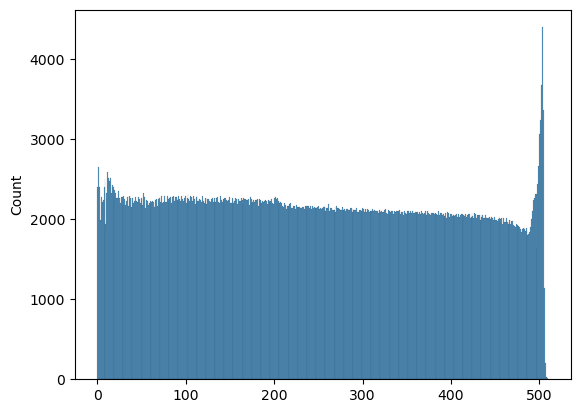

In [18]:
sns.histplot(ds_high.depth[my_obs].values, bins=500)